# This notebook has been tested with 
* Python 3.5
* Keras 2.0.6
* Tensorflow 1.2.1

In [1]:
from PIL import Image
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D

Using TensorFlow backend.


# Load Training examples

In [2]:
def load_data(data_list, sourceFile, label, imageSize):
    photoList = os.listdir(sourceFile)
    for photo in photoList:
        img = Image.open(sourceFile+photo)
        rsize = img.resize((imageSize, imageSize))
        rsizeArr = np.asarray(rsize)
        rsize_la = (rsizeArr, label)
        data_list.append(rsize_la)  

In [3]:
# Load training faces from directory
# 'female_faces_datagen/' is the source directory of female faces, and has been labeled '0' 
photoDir1 = 'female_faces_datagen/'
# 'male_faces_datagen/' is the source directory of male faces, and has been labeled '1'
photoDir2 = 'male_faces_datagen/'
x_data = []
# Set image size
imageSize = 96
load_data(x_data, photoDir1, 0, imageSize)
load_data(x_data, photoDir2, 1, imageSize)

train_length = int(len(x_data)*0.8)

np.random.shuffle(x_data)
x_data = list(zip(*x_data))

# Use 80% for training, and 20% for testing
x_train = np.asarray(list(x_data[0])[:train_length])
y_train = np.asarray(list(x_data[1])[:train_length])
x_test = np.asarray(list(x_data[0])[train_length:])
y_test = np.asarray(list(x_data[1])[train_length:])

# Feature scaling
x_train_nor = x_train.astype('float32') / 255.0
x_test_nor = x_test.astype('float32') / 255.0

# Build model architecture

In [4]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(5,5),
                 input_shape=(imageSize, imageSize, 3), 
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(rate=0.8))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

# Train the model

In [200]:
train_history=model.fit(x_train_nor, y_train,
                        validation_split=0.2,
                        epochs=1, batch_size=64, verbose=1) 

Train on 28912 samples, validate on 7228 samples
Epoch 1/1
28912/28912 [==============================] - 68s - loss: 0.1225 - acc: 0.9507 - val_loss: 0.1624 - val_acc: 0.9373


# Show training history

In [7]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

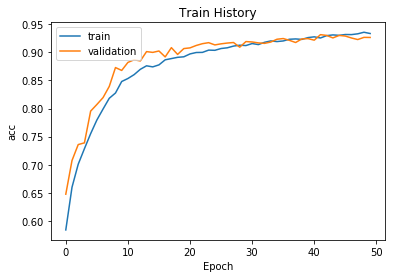

In [8]:
show_train_history(train_history, 'acc', 'val_acc')

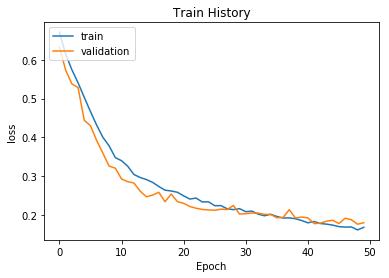

In [9]:
show_train_history(train_history, 'loss', 'val_loss')

# Save model

In [223]:
# Only save weights, need to create model before load weights
#model.save_weights("gender_classify_middle_hiar_man.h5")
# Save entire model
model.save('gender_classify_middle_hiar_man.h5')

# Evaluate public testing set 

In [201]:
scores = model.evaluate(x_test_nor, 
                        y_test, verbose=0)
scores[1]

0.93559096948189668

In [202]:
prediction=model.predict_classes(x_test_nor)
prediction.shape

9024/9036 [============================>.] - ETA: 0s

(9036, 1)

In [203]:
# Draw confusion matrix
pd.crosstab(y_test,prediction.reshape(-1),
            rownames=['label'],colnames=['predict'])

predict,0,1
label,,
0,4320,295
1,287,4134


# Evaluate private test set

In [227]:
# Load testing images from directory
# 'female_test_final/' is the source directory of female faces, and have been labeled '0' 
photoDir1 = 'female_test_final/'
# 'male_test_final/' is the source directory of male faces, and have been labeled '1'
photoDir2 = 'male_test_final/'
x_data_alt = []

load_data(x_data_alt, photoDir1, 0, imageSize)
load_data(x_data_alt, photoDir2, 1, imageSize)

x_data_alt = list(zip(*x_data_alt))
x_test_alt = np.asarray(list(x_data_alt[0]))
y_test_alt = np.asarray(list(x_data_alt[1]))

# Feature scaling
x_test_alt_nor = x_test_alt.astype('float32') / 255.0

In [224]:
# Only load weights, need to create model before load weights
#model.load_weights("gender_classify_middle_hiar_man.h5")
# Load entire model
model = load_model('gender_classify_middle_hiar_man.h5')

In [228]:
scores = model.evaluate(x_test_alt_nor, 
                        y_test_alt, verbose=0)
scores[1]

1.0

In [229]:
prediction=model.predict_classes(x_test_alt_nor)
prediction.shape

20/20 [==============================] - 0s


(20, 1)

In [230]:
# Draw confusion matrix
pd.crosstab(y_test_alt,prediction.reshape(-1),
            rownames=['label'],colnames=['predict'])

predict,0,1
label,,
0,10,0
1,0,10


# Plot images with label and prediction

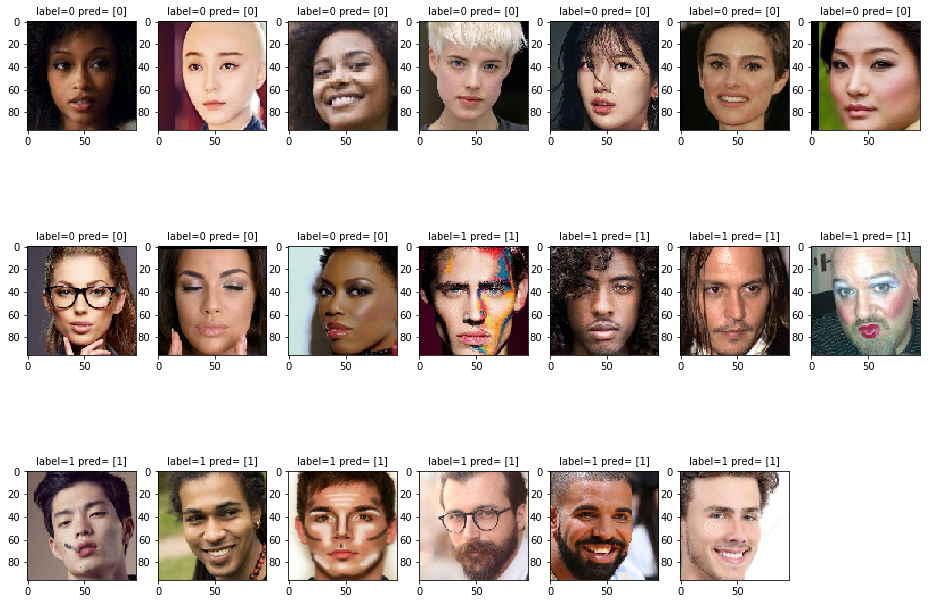

In [231]:
fig = plt.gcf()
fig.set_size_inches(16,20)
for i in range(len(x_test_alt)):
    ax = plt.subplot(5,7,1+i)
    ax.imshow(x_test_alt[i], cmap='binary')
    title ="label=" + str(y_test_alt[i]) + " pred= " +str(prediction[i]) 
    ax.set_title(title,fontsize=10)
plt.show()